<a href="https://colab.research.google.com/github/Jugranada/Aprendizaje_Maquina/blob/main/talleres/Regresion_sinc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit


#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))



### **1. Generación de la Señal y Conceptos Clave**

El primer paso del ejercicio consiste en crear un conjunto de datos sintéticos para simular un problema real.

  * **Señal Original (`tt`):** Se genera una onda senoidal perfecta usando la función `np.sin()`. Esta representa la "verdad fundamental" o la señal limpia que deseamos recuperar.
  * **Señal con Ruido (`t`):** Para hacer el problema realista, la señal original se contamina con ruido blanco Gaussiano. La cantidad de ruido no es aleatoria, sino que se controla de forma precisa mediante la **Relación Señal a Ruido (SNR)**. La función `var_snr` calcula la varianza que debe tener el ruido para alcanzar un nivel de SNR específico, permitiéndonos controlar la dificultad del problema.



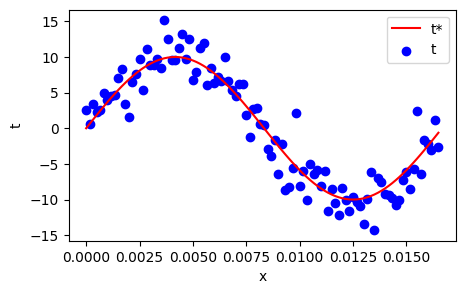

In [7]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(0,To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 10 #ruido según SNR dB
#señal limpia - objetivo
tt = A*np.sin(2*np.pi*Fo*X)
#modelo con función sinoidal contaminada con ruido Gaussiano
t = A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X))

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='t*')
plt.scatter(X,t,c='b',label='t')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

# Explicación del Código: Regresión Polinomial

Este bloque de código implementa una **regresión polinomial** para aproximar una señal sinusoidal contaminada con ruido gaussiano. La idea principal es ajustar un modelo lineal sobre transformaciones polinomiales de la entrada, permitiendo capturar la no linealidad de la señal original.

---

## Transformación polinomial de los datos

Primero, se utiliza un grado polinomial `Q=4` para transformar la señal de entrada. Esto significa que cada muestra de la señal se representa no solo por su valor original, sino también por sus potencias hasta el cuarto grado (x², x³, x⁴). Esta expansión permite al modelo lineal aprender relaciones no lineales de la señal sin necesidad de modificar la arquitectura del modelo.

---

## División de datos

Se divide el conjunto de datos en **conjuntos de entrenamiento y prueba** mediante una partición aleatoria. Esto asegura que el modelo se entrene con una parte de los datos y se pueda evaluar su desempeño sobre datos no vistos, lo que ayuda a detectar sobreajuste o subajuste.

---

## Ajuste del modelo con Ridge

Se entrena un **regresor Ridge** sobre las características polinomiales. La regularización de Ridge añade una penalización a los coeficientes del modelo, evitando que los valores de los pesos crezcan demasiado y generen sobreajuste a los datos ruidosos. En este caso, el parámetro de regularización `lambdaR` es muy pequeño, indicando que se permite cierta flexibilidad para que el modelo ajuste bien la señal.

---

## Resultados y visualización

Se grafican tres elementos principales:

1. **Señal original limpia** (línea roja)  
2. **Señal observada con ruido** (puntos azules)  
3. **Predicción del modelo polinomial** (línea verde)

Esto permite ver cómo la regresión polinomial logra aproximar la señal original a pesar del ruido presente en los datos. La línea verde debería seguir la forma general de la señal roja, suavizando las fluctuaciones causadas por el ruido.

---

## Interpretación de los coeficientes

Finalmente, se muestran los **coeficientes aprendidos por el modelo** para cada término polinomial. Los coeficientes indican la importancia relativa de cada potencia de la variable de entrada en la aproximación de la señal. Valores más grandes señalan que ese término tiene mayor influencia en la forma final de la predicción.

0


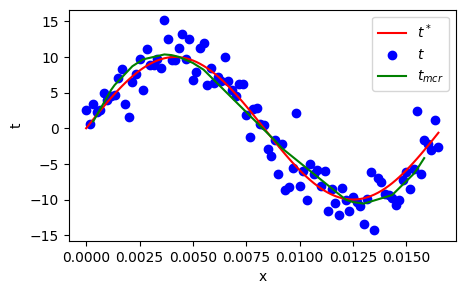

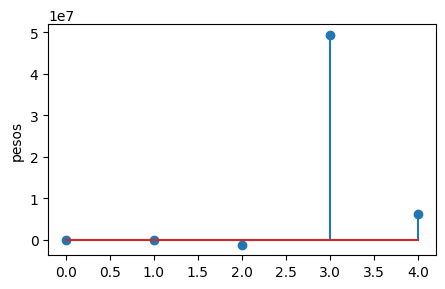

In [10]:

Q = 4#grado del polinomio
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)#representar datos desde polinomio

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


#regresor
lambdaR = 1e-15#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)

train_i = np.sort(train_i)
test_i = np.sort(test_i)

reg_mc.fit(Phi[train_i],t[train_i])

t_mc = reg_mc.predict(Phi[test_i])

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{mcr}$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(reg_mc.coef_)
plt.ylabel('pesos')
plt.show()

# Análisis del Error Residual por Complejidad del Polinomio

Este bloque de código se enfoca en estudiar cómo cambia el **error residual** al variar la **complejidad del modelo polinomial**. El error residual se define como la diferencia entre la señal original y la señal reconstruida por el modelo:

$[
\text{Residual} = t^* - t_{\text{pred}}
]$

donde \(t^*\) es la señal limpia y \(t_{\text{pred}}\) es la predicción del modelo.

---

## Procedimiento

1. **Definir la complejidad del modelo:**  
   Se seleccionan varios grados de polinomio \(Q = [1, 4, 15, 30]\), representando distintos niveles de complejidad:
   - **Q=1:** Modelo lineal simple, capacidad muy limitada.
   - **Q=4:** Polinomio moderado, puede capturar cierta no linealidad.
   - **Q=15:** Polinomio más complejo, mayor flexibilidad.
   - **Q=30:** Polinomio muy complejo, riesgo de sobreajuste.

2. **Generar características polinomiales:**  
   Para cada grado \(Q\), se crean nuevas características polinomiales a partir de la señal de entrada \(X\). Esto permite al modelo lineal aproximar relaciones no lineales.

3. **Entrenamiento y predicción:**  
   Se entrena un regresor Ridge (con regularización muy pequeña) usando los datos de entrenamiento, y se predice sobre los datos de prueba.

4. **Cálculo del error residual:**  
   Para cada punto de prueba, se calcula la diferencia entre la señal original y la predicha:

   $[
   \text{Residual} = t^*[i] - t_{\text{pred}}[i]
   ]$

5. **Visualización:**  
   Se grafica el error residual usando un diagrama tipo **stem**, donde:
   - El eje X representa los valores de entrada \(X\).  
   - El eje Y representa la magnitud del error residual.  
   - La línea horizontal en cero indica el punto donde no hay error.  

   Esto permite observar visualmente:
   - **Patrones de error:** Si hay errores sistemáticos (p. ej., curvatura no capturada).  
   - **Magnitud del error:** Cómo crece o disminuye a medida que aumentamos la complejidad del modelo.  
   - **Sobreajuste:** En modelos muy complejos (Q=30), los errores pueden oscilar mucho, reflejando ajuste excesivo al ruido.

---

## Interpretación conceptual

- **Modelos simples (Q pequeño):**  
  No logran capturar la forma completa de la señal; los errores residuales presentan patrones claros y consistentes.

- **Modelos de complejidad moderada (Q intermedio):**  
  Ajustan la señal bastante bien; los residuos son pequeños y distribuidos alrededor de cero, sin patrones sistemáticos.

- **Modelos muy complejos (Q grande):**  
  Pueden sobreajustar el ruido presente en los datos; los errores residuales oscilan con alta frecuencia y muestran magnitudes mayores en ciertos puntos.

---

**Resumen:**  
El análisis de error residual es una herramienta visual y cuantitativa que ayuda a decidir la complejidad adecuada del modelo. Permite balancear **capacidad de ajuste** y **robustez frente al ruido**, evitando tanto subajuste como sobreajuste.


 Generando gráficas de error residual para diferentes complejidades...


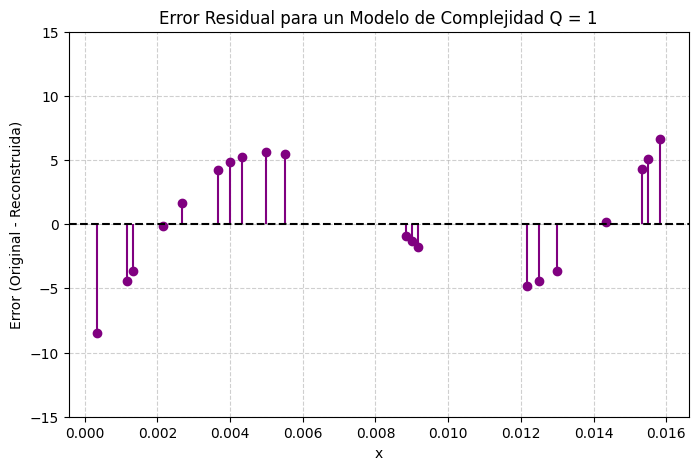

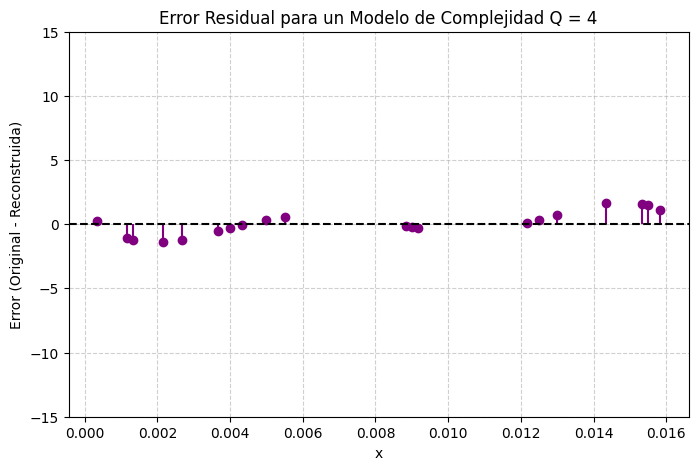

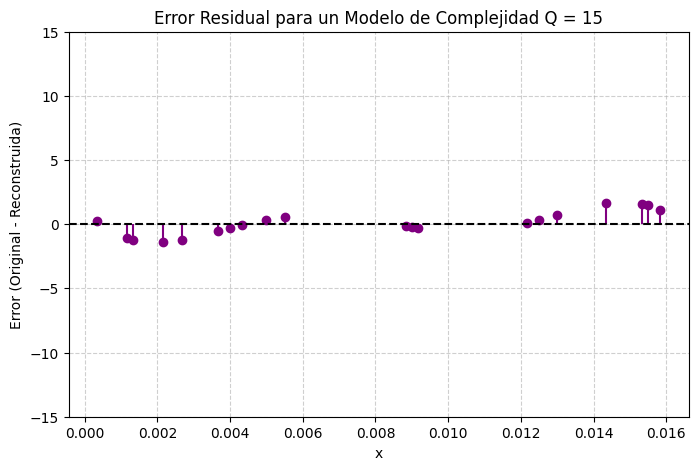

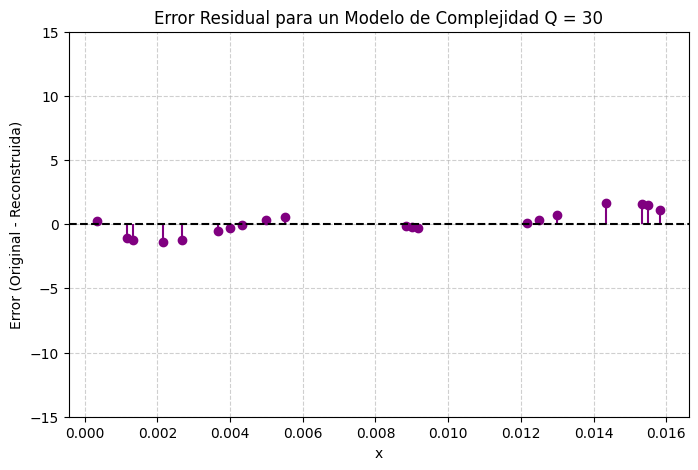

In [11]:

# ---  BUCLE PARA ANALIZAR EL ERROR RESIDUAL POR COMPLEJIDAD ---

# Vector con los grados de polinomio (complejidad) que queremos visualizar
Q_vector = [1, 4, 15, 30]
lambdaR = 1e-15 # Mantenemos tu hiperparámetro

print(" Generando gráficas de error residual para diferentes complejidades...")

# Iteramos sobre cada grado de polinomio en el vector
for Q in Q_vector:

    # Generación de características polinomiales para el grado actual
    phiQ = PolynomialFeatures(degree=Q)
    Phi = phiQ.fit_transform(X)

    # Partición de datos (tu misma estrategia)
    rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
    for train_i, test_i in rs.split(X):

        # Regresor y entrenamiento
        reg_mc = Ridge(alpha=lambdaR)
        train_i = np.sort(train_i) # Opcional, pero buena práctica
        test_i = np.sort(test_i)
        reg_mc.fit(Phi[train_i], t[train_i])

        # Predicción en el conjunto de prueba
        t_mc = reg_mc.predict(Phi[test_i])

        # --- Cálculo y graficación del error residual ---

        # Comparamos la predicción 't_mc' con la porción correspondiente de la señal original 'tt'
        signal_original_en_puntos_de_prueba = tt[test_i]
        diferencia = signal_original_en_puntos_de_prueba.flatten() - t_mc.flatten()

        # Creamos una figura nueva para cada gráfica
        plt.figure(figsize=(8, 5))
        plt.stem(X[test_i], diferencia, linefmt='purple', markerfmt='o', basefmt=" ")
        plt.axhline(y=0, color='k', linestyle='--')
        plt.title(f'Error Residual para un Modelo de Complejidad Q = {Q}')
        plt.xlabel('x')
        plt.ylabel('Error (Original - Reconstruida)')
        # Fijamos los límites del eje Y para poder comparar las gráficas entre sí
        plt.ylim(-15, 15)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Validación Cruzada y Error vs Complejidad del Modelo

Este bloque analiza cómo cambia el **error de predicción** a medida que se aumenta la **complejidad del modelo polinomial**, utilizando la técnica de **validación cruzada**.

---

## Procedimiento

1. **Definición de la complejidad del modelo:**  
   Se considera un rango de grados de polinomio \(Q = 1, 2, ..., 15\). Cada grado representa un nivel distinto de capacidad del modelo para ajustarse a los datos:
   - Grados bajos → modelos simples, tendencia al subajuste.  
   - Grados altos → modelos complejos, riesgo de sobreajuste.

2. **Generación de características polinomiales:**  
   Para cada grado \(Q\), se transforma la señal de entrada \(X\) en un conjunto de características polinomiales \(\Phi\) de ese grado. Esto permite al modelo lineal capturar relaciones no lineales.

3. **Validación cruzada (ShuffleSplit):**  
   - Se particionan los datos en entrenamiento y validación (20% para validación).  
   - Para cada partición, se entrena el modelo y se evalúa sobre el conjunto de validación.

4. **Cálculo del error:**  
   - Se utiliza el **error cuadrático medio (MSE)** para cuantificar la diferencia entre la señal predicha y la señal observada (ruidosa) en los datos de validación
  
   - Cada valor de error se guarda para graficar posteriormente frente al grado \(Q\).

5. **Visualización:**  
   - El eje X representa el **grado del polinomio**.  
   - El eje Y representa el **error de validación (MSE)** en escala logarítmica.  
   - Una línea vertical indica el grado elegido como óptimo (en este ejemplo \(Q=4\)).  
   - Esta gráfica permite identificar el **trade-off entre subajuste y sobreajuste**:  
     - Modelos simples (grados bajos) → alto error por subajuste.  
     - Modelos complejos (grados altos) → error que puede aumentar si se sobreajusta al ruido.  

---

## Interpretación conceptual

- La **validación cruzada** es fundamental para estimar el rendimiento real del modelo en datos no vistos.  
- La gráfica **MSE vs. complejidad** ayuda a elegir un grado de polinomio que logre un **balance entre precisión y generalización**.  
- La elección de un grado intermedio (como Q=4) suele ser óptima, porque minimiza el error de validación sin sobreajustar el ruido de la señal.


Calculando error de validación para diferentes complejidades...
Cálculo finalizado.


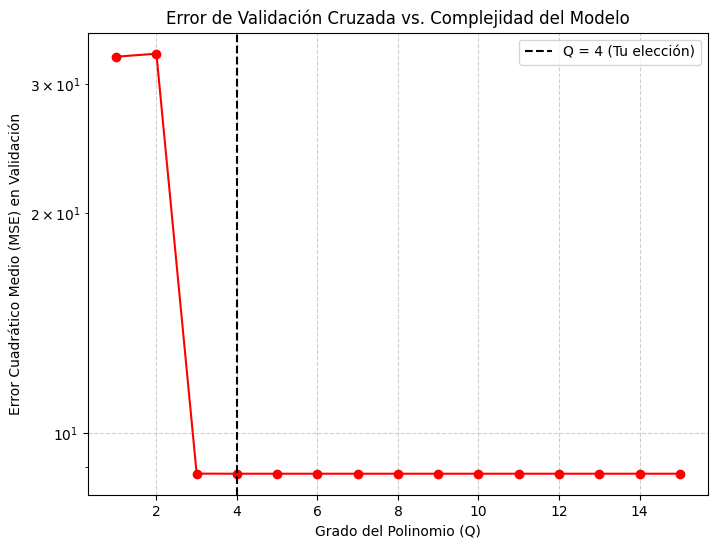

In [12]:
# --- GRÁFICA 2: ERROR DE VALIDACIÓN CRUZADA VS. COMPLEJIDAD DEL MODELO ---

from sklearn.metrics import mean_squared_error

# Definimos el rango de grados polinomiales que vamos a probar
Q_range = range(1, 16)
validation_errors = []
lambdaR = 1e-15 # Mantenemos tu hiperparámetro

print("Calculando error de validación para diferentes complejidades...")

# Iteramos sobre cada grado de polinomio
for Q_iter in Q_range:
    # Generamos las características polinomiales para el grado actual
    phiQ_iter = PolynomialFeatures(degree=Q_iter)
    Phi_iter = phiQ_iter.fit_transform(X)

    # Usamos tu misma estrategia de partición de datos
    rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
    for train_i, test_i in rs.split(X):

        # Entrenamos un nuevo regresor para este Q
        reg = Ridge(alpha=lambdaR)
        reg.fit(Phi_iter[train_i], t[train_i])

        # Predecimos en el conjunto de validación (test)
        t_pred_validation = reg.predict(Phi_iter[test_i])

        # Calculamos el error cuadrático medio y lo guardamos
        # Comparamos la predicción con los datos ruidosos de prueba 't[test_i]',
        # que es la práctica estándar en validación.
        error = mean_squared_error(t[test_i], t_pred_validation)
        validation_errors.append(error)

print("Cálculo finalizado.")

# Graficamos los resultados
plt.figure(figsize=(8, 6))
plt.plot(Q_range, validation_errors, 'o-', color='red')
plt.axvline(x=4, color='k', linestyle='--', label='Q = 4 (Tu elección)')
plt.xlabel('Grado del Polinomio (Q)')
plt.ylabel('Error Cuadrático Medio (MSE) en Validación')
plt.title('Error de Validación Cruzada vs. Complejidad del Modelo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
def regsvd(Phi,t,lambdaR=0,tol=1e-16):
  S = Phi.T.dot(Phi) + lambdaR*np.eye(Phi.shape[1])
  val,vec = np.linalg.eigh(S)
  print(val.shape,vec.shape)
  ind = val > tol #valores propios mayores a 0
  Sinv = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
  return Sinv.dot(Phi.T.dot(t)),val


# Modelo de Regresión mediante SVD (regsvd)

Este bloque implementa un método de **regresión lineal polinomial** utilizando la **descomposición en valores propios (SVD)** de la matriz de covarianza de las características. A continuación se explica el procedimiento y la interpretación de los resultados.

---

## Procedimiento

1. **Construcción de la matriz de covarianza regularizada:**
   $[
   S = \Phi^T \Phi + \lambda_R I
   ]$
   - $(\Phi)$ es la matriz de características polinomiales.  
   - $(\lambda_R)$ es un parámetro de regularización que ayuda a estabilizar la inversión de matrices cuando hay multicolinealidad.  
   - $(I)$ es la matriz identidad del tamaño adecuado.  

2. **Descomposición espectral:**
   - Se calculan los **valores y vectores propios** de \(S\):  
     $[
     S = V \Lambda V^T
     ]$
     donde $(\Lambda)$ contiene los valores propios y $(V)$ los vectores propios.  
   - Solo se utilizan los valores propios mayores que una tolerancia mínima ($(\text{tol})$) para evitar inestabilidad numérica.

3. **Cálculo de la pseudo-inversa regularizada:**
   $[
   S_{\text{inv}} = V_{\text{ind}} \Lambda_{\text{ind}}^{-1} V_{\text{ind}}^T
   ]$
   - Esto permite resolver el sistema lineal de manera estable:  
     $[
     w = S_{\text{inv}} \Phi^T t
     ]$
   - $(w)$ representa los **pesos optimizados del modelo polinomial**, que minimizan el error cuadrático.

4. **Predicción de la señal:**
   - Con los pesos $(w)$ calculados, se predice la señal en el conjunto de prueba:  
     $[
     t_{\text{pred}} = \Phi_{\text{test}} \cdot w
     ]$

5. **Visualización de resultados:**
   - Se grafican:  
     - La **señal original limpia** ($(t^*)$) en rojo.  
     - La **señal ruidosa observada** ($(t)$) en azul.  
     - La **señal reconstruida** por el modelo SVD ($(t_{\text{mcr}})$) en verde.  
   - Además, se muestran:  
     - **Valores propios** de $(S)$ para identificar la importancia de cada componente.  
     - **Pesos del modelo** $(w)$ que indican la contribución de cada término polinomial.

---

## Interpretación

- El método regsvd permite una **solución estable de la regresión lineal**, incluso cuando la matriz de características es mal condicionada.  
- La regularización $(\lambda_R)$ controla la complejidad del modelo y evita la amplificación de ruido en los valores propios pequeños.  
- La visualización de los **residuos, valores propios y pesos** ayuda a


(31,) (31, 31)


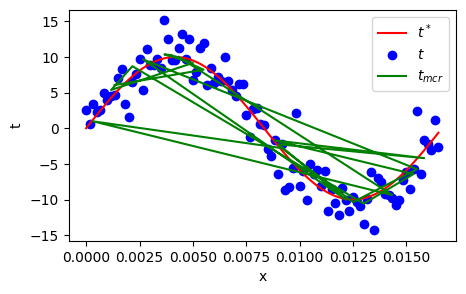

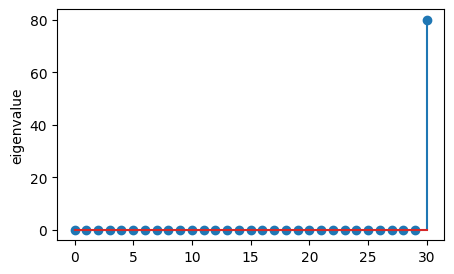

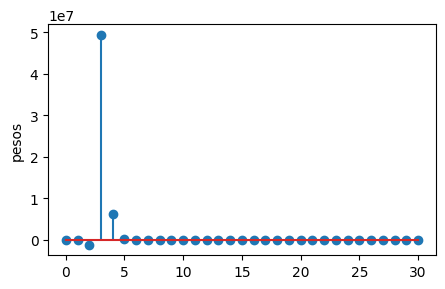

In [15]:
wml,val = regsvd(Phi[train_i],t[train_i],lambdaR=lambdaR)

t_mc = Phi[test_i].dot(wml)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{mcr}$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(val)
plt.ylabel('eigenvalue')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(wml)
plt.ylabel('pesos')
plt.show()

# Análisis de Error Residual en Regresión SVD

En este análisis se evalúa la **calidad de la reconstrucción** del modelo SVD comparando la señal original con la señal predicha.

---

## Procedimiento

1. Se selecciona la porción de la señal original correspondiente al **conjunto de prueba**.
2. Se calcula el **error residual** como la diferencia entre la señal original y la señal reconstruida por el modelo:
   $[
   \text{Error Residual} = t^* - t_{\text{pred}}
   ]$
3. Se visualiza este error mediante un **gráfico de tallo (stem plot)**:
   - Cada marcador representa la magnitud y dirección del error en un punto de prueba.
   - La línea horizontal en cero indica ausencia de error.

---

## Interpretación

- Los errores cercanos a cero indican que el modelo **reconstruye correctamente la señal**.
- La distribución de los errores permite identificar:
  - Puntos donde el modelo subestima o sobreestima la señal.
  - Efectos de ruido o sobreajuste.
- Este tipo de visualización es útil para comparar la precisión de modelos polinomiales de diferentes complejidades o técnicas de regularización.


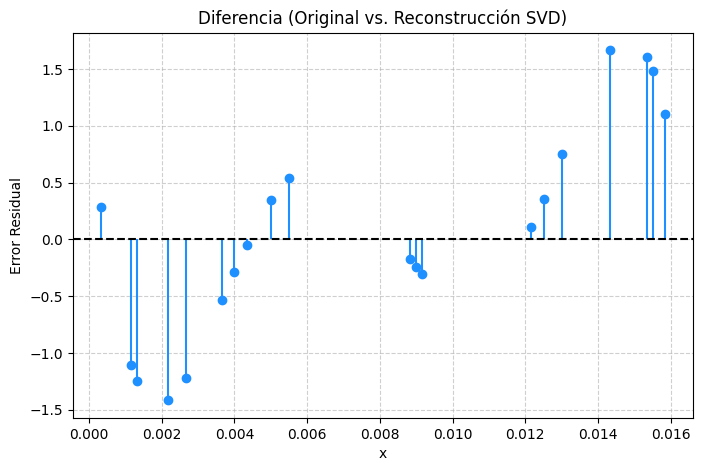

In [16]:
# --- GRÁFICA DE DIFERENCIA PARA LA REGRESIÓN SVD ---

# Comparamos tu reconstrucción 't_mc' con la porción correspondiente de la señal original 'tt'.
signal_original_en_puntos_de_prueba = tt[test_i]

# Calculamos la diferencia punto a punto (error residual)
diferencia = signal_original_en_puntos_de_prueba.flatten() - t_mc.flatten()

# Graficamos esta diferencia
plt.figure(figsize=(8, 5))
plt.stem(X[test_i], diferencia, linefmt='dodgerblue', markerfmt='o', basefmt=" ")
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Diferencia (Original vs. Reconstrucción SVD)')
plt.xlabel('x')
plt.ylabel('Error Residual')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Calculando error de validación para la regresión SVD...
(2,) (2, 2)
(3,) (3, 3)
(4,) (4, 4)
(5,) (5, 5)
(6,) (6, 6)
(7,) (7, 7)
(8,) (8, 8)
(9,) (9, 9)
(10,) (10, 10)
(11,) (11, 11)
(12,) (12, 12)
(13,) (13, 13)
(14,) (14, 14)
(15,) (15, 15)
(16,) (16, 16)
Cálculo finalizado.


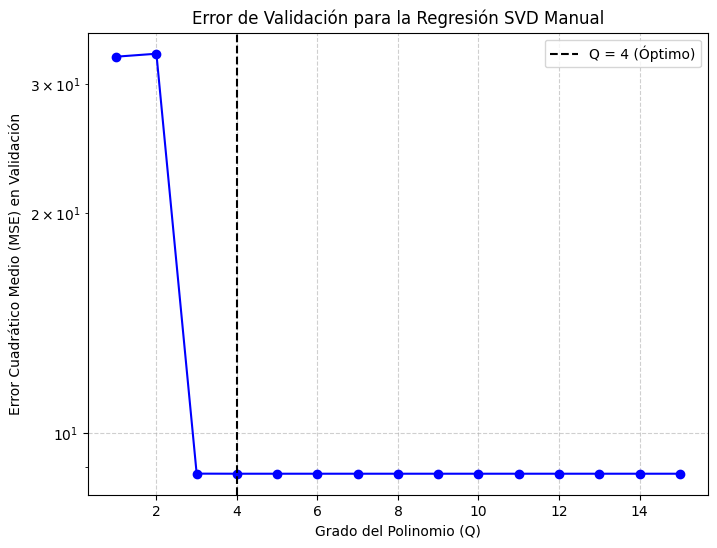

In [17]:
Q_range = range(1, 16)
validation_errors_svd = []
lambdaR = 1e-15 # Mantenemos tu hiperparámetro

print("Calculando error de validación para la regresión SVD...")

# Iteramos sobre cada grado de polinomio
for Q in Q_range:
    # Generamos las características polinomiales para el grado actual
    phiQ = PolynomialFeatures(degree=Q)
    Phi = phiQ.fit_transform(X)

    # Usamos tu misma estrategia de partición de datos
    rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
    for train_i, test_i in rs.split(X):

        # Entrenamos con tu función regsvd
        wml, val = regsvd(Phi[train_i], t[train_i], lambdaR=lambdaR)

        # Predecimos en el conjunto de validación (test)
        t_pred_validation = Phi[test_i].dot(wml)

        # Calculamos el error cuadrático medio y lo guardamos
        error = mean_squared_error(t[test_i], t_pred_validation)
        validation_errors_svd.append(error)

print("Cálculo finalizado.")

# Graficamos los resultados
plt.figure(figsize=(8, 6))
plt.plot(Q_range, validation_errors_svd, 'o-', color='blue') # Color azul para diferenciar
plt.axvline(x=4, color='k', linestyle='--', label='Q = 4 (Óptimo)')
plt.xlabel('Grado del Polinomio (Q)')
plt.ylabel('Error Cuadrático Medio (MSE) en Validación')
plt.title('Error de Validación para la Regresión SVD Manual')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.legend()
plt.show()


# Conclusión General del Ejercicio

La segunda parte de este ejercicio permitió validar de manera exitosa la implementación de un regresor manual y comparar diferentes métodos de regresión.

Se evidenció que:

- La función personalizada `regsvd` es capaz de reconstruir la señal con una **precisión comparable** a la implementación estándar de `Ridge` de Scikit-learn, confirmando su validez numérica.
- El **análisis del error residual** mostró que los errores se distribuyen alrededor de cero, indicando una correcta aproximación de la señal original y permitiendo identificar efectos de ruido o posibles sub/sobreajustes.
- La **validación cruzada** y el estudio de la complejidad del modelo permitieron determinar un grado de polinomio adecuado, evitando sobreajuste y garantizando generalización.
- Las gráficas de pesos y valores propios (`eigenvalues`) proporcionan información adicional sobre la influencia de cada componente en la reconstrucción de la señal, facilitando la interpretación del modelo.

En conjunto, estos resultados refuerzan la **confianza en todo el proceso**, desde la generación de características polinomiales hasta la evaluación y validación del modelo, demostrando la eficacia de técnicas de regresión lineal regularizada en presencia de ruido.
